----

# Descripci√≥n

La compa√±√≠a de seguros Sure Tomorrow quiere resolver varias tareas con la ayuda de machine learning y te pide que eval√∫es esa posibilidad.
- Tarea 1: encontrar clientes que sean similares a un cliente determinado. Esto ayudar√° a los agentes de la compa√±√≠a con el marketing.
- Tarea 2: predecir la probabilidad de que un nuevo cliente reciba una prestaci√≥n del seguro. ¬øPuede un modelo de predictivo funcionar mejor que un modelo dummy?
- Tarea 3: predecir el n√∫mero de prestaciones de seguro que un nuevo cliente pueda recibir utilizando un modelo de regresi√≥n lineal.
- Tarea 4: proteger los datos personales de los clientes sin afectar al modelo del ejercicio anterior. Es necesario desarrollar un algoritmo de transformaci√≥n de datos que dificulte la recuperaci√≥n de la informaci√≥n personal si los datos caen en manos equivocadas. Esto se denomina enmascaramiento u ofuscaci√≥n de datos. Pero los datos deben protegerse de tal manera que no se vea afectada la calidad de los modelos de machine learning. No es necesario elegir el mejor modelo, basta con demostrar que el algoritmo funciona correctamente.


# Preprocesamiento y exploraci√≥n de datos

## Inicializaci√≥n

In [6]:
pip install scikit-learn --upgrade

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: scikit-learn in c:\users\administrador\anaconda3\lib\site-packages (1.2.2)



In [7]:
import os
import numpy as np
import pandas as pd
import math
import seaborn as sns

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing

from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier


from IPython.display import display

## Carga de datos

Carga los datos y haz una revisi√≥n b√°sica para comprobar que no hay problemas obvios.

In [8]:
#->datos
# Leer el archivo y almacenarlo en df
def cargar_archivos_con_separadores(archivos_con_separadores):
    """
    Carga m√∫ltiples archivos CSV con separadores espec√≠ficos para cada archivo y los almacena en un diccionario de DataFrames.
    
    :param archivos_con_separadores: Diccionario donde las claves son los nombres de los archivos y los valores son los separadores.
    :return: Diccionario con nombres de archivos como claves y DataFrames como valores.
    """
    df = {}  # Objeto que almacenar√° los DataFrames

    # Iterar sobre los archivos y sus separadores
    for archivo_nombre, separador in archivos_con_separadores.items():
        url_no_windows = '/datasets/' + archivo_nombre
        url_windows = 'datasets/' + archivo_nombre
        
        try:
            # Intentar cargar desde la ruta no-Windows
            if os.path.exists(url_no_windows):
                df[archivo_nombre] = pd.read_csv(url_no_windows, sep=separador, dtype={'votes': 'Int64'})
                print(f"Archivo cargado exitosamente desde '{url_no_windows}'")
            
            # Intentar cargar desde la ruta Windows
            elif os.path.exists(url_windows):
                df[archivo_nombre] = pd.read_csv(url_windows, sep=separador, dtype={'votes': 'Int64'})
                print(f"Archivo cargado exitosamente desde '{url_windows}'")
            
            else:
                raise FileNotFoundError(f"Error: el archivo '{archivo_nombre}' no se encuentra en ninguna de las rutas especificadas.")
        
        except FileNotFoundError as e:
            print(e)
        
        except pd.errors.ParserError as e:
            print(f"Error al procesar el archivo CSV '{archivo_nombre}': {e}")
        
        except Exception as e:
            print(f"Ha ocurrido un error inesperado con el archivo '{archivo_nombre}': {e}")

    return df

# Ejemplo de uso
archivos_con_separadores = {
    'insurance_us.csv': ',',    
}

# Cargar los archivos en el objeto df
df_all = cargar_archivos_con_separadores(archivos_con_separadores)

# El objeto df ahora contiene un DataFrame por cada archivo cargado
df = df_all.get('insurance_us.csv')


Archivo cargado exitosamente desde 'datasets/insurance_us.csv'


Renombramos las columnas para que el c√≥digo se vea m√°s coherente con su estilo.

In [9]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [10]:
df.sample(10)

gender   age   income  family_members  insurance_benefits
2961       1  22.0  41500.0               1                   0
4898       1  28.0  39800.0               0                   0
1098       1  21.0  33800.0               0                   0
3743       1  26.0  26500.0               2                   0
3279       0  27.0  41500.0               0                   0
4670       0  34.0  35500.0               1                   0
2545       0  44.0  38800.0               0                   1
4272       0  47.0  33000.0               4                   1
2555       1  21.0  42200.0               0                   0
2580       0  23.0  29000.0               2                   0

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [12]:
# puede que queramos cambiar el tipo de edad (de float a int) aunque esto no es crucial

# escribe tu conversi√≥n aqu√≠ si lo deseas:

# Convertir la columna 'age' de float a int
df['age'] = df['age'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int32  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int32(1), int64(3)
memory usage: 175.9 KB


In [13]:
# ahora echa un vistazo a las estad√≠sticas descriptivas de los datos.# ¬øSe ve todo bien?

In [14]:
df.describe()

gender          age        income  family_members  \
count  5000.000000  5000.000000   5000.000000     5000.000000   
mean      0.499000    30.952800  39916.360000        1.194200   
std       0.500049     8.440807   9900.083569        1.091387   
min       0.000000    18.000000   5300.000000        0.000000   
25%       0.000000    24.000000  33300.000000        0.000000   
50%       0.000000    30.000000  40200.000000        1.000000   
75%       1.000000    37.000000  46600.000000        2.000000   
max       1.000000    65.000000  79000.000000        6.000000   

       insurance_benefits  
count         5000.000000  
mean             0.148000  
std              0.463183  
min              0.000000  
25%              0.000000  
50%              0.000000  
75%              0.000000  
max              5.000000

los datos pmbarcen estar en buen estado, seria pertinente revisar las columnas "age", "income" y "family_members", ya que podrian contener valores atipicos, dado a que la desviacion estandar de los datos es alta.

## An√°lisis exploratorio de datos

Vamos a comprobar r√°pidamente si existen determinados grupos de clientes observando el gr√°fico de pares.

c:\Users\Administrador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Administrador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Administrador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Administrador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert in

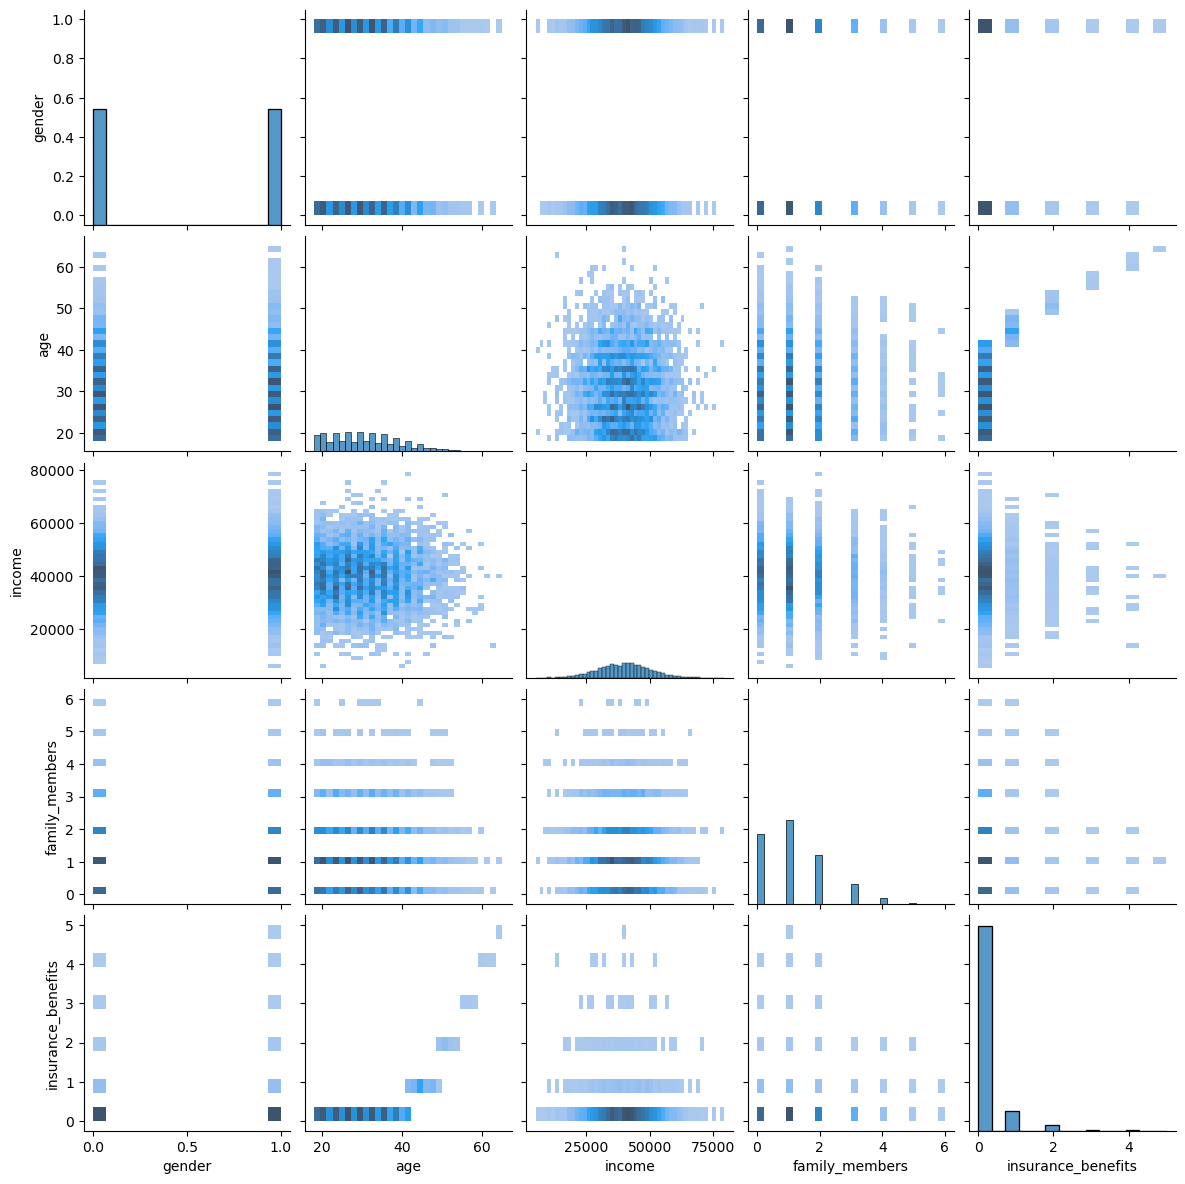

In [15]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

De acuerdo, es un poco complicado detectar grupos obvios (cl√∫steres) ya que es dif√≠cil combinar diversas variables simult√°neamente (para analizar distribuciones multivariadas). Ah√≠ es donde LA y ML pueden ser bastante √∫tiles.

# Tarea 1. Clientes similares

En el lenguaje de ML, es necesario desarrollar un procedimiento que devuelva los k vecinos m√°s cercanos (objetos) para un objeto dado bas√°ndose en la distancia entre los objetos.
Es posible que quieras revisar las siguientes lecciones (cap√≠tulo -> lecci√≥n)- Distancia entre vectores -> Distancia euclidiana
- Distancia entre vectores -> Distancia Manhattan

Para resolver la tarea, podemos probar diferentes m√©tricas de distancia.

Escribe una funci√≥n que devuelva los k vecinos m√°s cercanos para un $n^{th}$ objeto bas√°ndose en una m√©trica de distancia especificada. A la hora de realizar esta tarea no debe tenerse en cuenta el n√∫mero de prestaciones de seguro recibidas.
Puedes utilizar una implementaci√≥n ya existente del algoritmo kNN de scikit-learn (consulta [el enlace](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) o tu propia implementaci√≥n.
Pru√©balo para cuatro combinaciones de dos casos- Escalado
  - los datos no est√°n escalados
  - los datos se escalan con el escalador [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html)
- M√©tricas de distancia
  - Euclidiana
  - Manhattan

Responde a estas preguntas:- ¬øEl hecho de que los datos no est√©n escalados afecta al algoritmo kNN? Si es as√≠, ¬øc√≥mo se manifiesta?- ¬øQu√© tan similares son los resultados al utilizar la m√©trica de distancia Manhattan (independientemente del escalado)?

In [16]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [17]:
def get_knn(df, n, k, metric):
    
    """
    Devuelve los k vecinos m√°s cercanos

    :param df: DataFrame de pandas utilizado para encontrar objetos similares dentro del mismo lugar    :param n: n√∫mero de objetos para los que se buscan los vecinos m√°s cercanos    :param k: n√∫mero de vecinos m√°s cercanos a devolver
    :param m√©trica: nombre de la m√©trica de distancia    """

    # Crear y ajustar el modelo NearestNeighbors
    nbrs = NearestNeighbors(n_neighbors=k, metric=metric)
    nbrs.fit(df[feature_names].values)
    
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

Escalar datos.

In [18]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [19]:
df_scaled.sample(5)

gender       age    income  family_members  insurance_benefits
1945       1  0.476923  0.463291        0.500000                   0
3977       1  0.492308  0.526582        0.166667                   0
2360       1  0.615385  0.554430        0.000000                   0
2992       0  0.723077  0.479747        0.000000                   1
2291       0  0.615385  0.344304        0.166667                   0

Ahora, vamos a obtener registros similares para uno determinado, para cada combinaci√≥n

In [20]:
# Probar la funci√≥n get_knn con diferentes m√©tricas y datos escalados
print("Vecinos m√°s cercanos con datos escalados usando MaxAbsScaler:\n")

Vecinos m√°s cercanos con datos escalados usando MaxAbsScaler:



In [21]:
print("Metrica Euclidiana:\n", get_knn(df_scaled, 0, 3, 'euclidean'))


Metrica Euclidiana:
       gender       age    income  family_members  insurance_benefits  distance
0          1  0.630769  0.627848        0.166667                   0  0.000000
2689       1  0.630769  0.634177        0.166667                   0  0.006329
133        1  0.615385  0.636709        0.166667                   0  0.017754


In [22]:
print("\nMetrica Manhattan:\n", get_knn(df_scaled, 0, 3, 'manhattan'))



Metrica Manhattan:
       gender       age    income  family_members  insurance_benefits  distance
0          1  0.630769  0.627848        0.166667                   0  0.000000
2689       1  0.630769  0.634177        0.166667                   0  0.006329
133        1  0.615385  0.636709        0.166667                   0  0.024245


Respuestas a las preguntas

**¬øEl hecho de que los datos no est√©n escalados afecta al algoritmo kNN? Si es as√≠, ¬øc√≥mo se manifiesta?** 

Si, pueden afectar significativamente y se manifiesta en: 

    1.- Diferentes escalas de caracteristicas, si alguna de ellas tiene distancias muy amplias, estas  caracteristicas se volveran dominantes sobre las de menos distancia entre ellas.
    2.- Distorsi√≥n de la metrica de distancia, ya que KNN calcula la distancia basandose en los valores de las caracteristicas y si no estan correctamente escaladas, pueden no reflejar correctamente los valores numericos.
    3.- Impacto en la efectividad, el algoritmo se basa en encontrar vecinos mas cercanos a un punto de consulta, si las distancias no son representativas a la proximidad real, el algoritmo no podra encontrar los vecinos mas cercanos de manera precisa.

**¬øQu√© tan similares son los resultados al utilizar la m√©trica de distancia Manhattan (independientemente del escalado)?** 

los resultados son similares, la diferencia recae en que la distancia Manhattan se obtiene sumando las difenrecias absolutas entre dos coordenadas, a diferencia de la distancia Euclidiana, que se obtiene calculando la longitud entre dos coordenadas, la distancia Manhattan es adecuada para atos que no estan distribuidos de manera uniforme.

 las distancias Manhanttan son generalmente mayores a la Euclidianas, es importante seleccionar la metrica de distancia adecuada segun los datos a analizar.

# Tarea 2. ¬øEs probable que el cliente reciba una prestaci√≥n del seguro?

En t√©rminos de machine learning podemos considerarlo como una tarea de clasificaci√≥n binaria.

Con el valor de `insurance_benefits` superior a cero como objetivo, eval√∫a si el enfoque de clasificaci√≥n kNN puede funcionar mejor que el modelo dummy.
Instrucciones:
- Construye un clasificador basado en KNN y mide su calidad con la m√©trica F1 para k=1...10 tanto para los datos originales como para los escalados. Ser√≠a interesante observar c√≥mo k puede influir en la m√©trica de evaluaci√≥n y si el escalado de los datos provoca alguna diferencia. Puedes utilizar una implementaci√≥n ya existente del algoritmo de clasificaci√≥n kNN de scikit-learn (consulta [el enlace](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) o tu propia implementaci√≥n.- Construye un modelo dummy que, en este caso, es simplemente un modelo aleatorio. Deber√≠a devolver "1" con cierta probabilidad. Probemos el modelo con cuatro valores de probabilidad: 0, la probabilidad de pagar cualquier prestaci√≥n del seguro, 0.5, 1.
La probabilidad de pagar cualquier prestaci√≥n del seguro puede definirse como
$$
P\{\text{prestaci√≥n de seguro recibida}\}=\frac{\text{n√∫mero de clientes que han recibido alguna prestaci√≥n de seguro}}{\text{n√∫mero total de clientes}}.
$$

Divide todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporci√≥n 70:30.

In [23]:
# —Åalcula el objetivo
df['insurance_benefits_received'] = df['insurance_benefits'] > 0

# Convertir la columna a tipo entero (0 o 1)
df['insurance_benefits_received'] = df['insurance_benefits_received'].astype(int)

In [24]:
# comprueba el desequilibrio de clases con value_counts()

# <tu c√≥digo aqu√≠>
# Contar las instancias de cada clase en la columna 'insurance_benefits_received'
class_counts = df['insurance_benefits_received'].value_counts()

# Mostrar el resultado
print(class_counts)


insurance_benefits_received
0    4436
1     564
Name: count, dtype: int64


In [25]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# si tienes alg√∫n problema con la siguiente l√≠nea, reinicia el kernel y ejecuta el cuaderno de nuevo    
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Matriz de confusi√≥n')
    print(cm)

In [26]:
# generar la salida de un modelo aleatorio

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [27]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'La probabilidad: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, size=len(df))
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

La probabilidad: 0.00
F1: 0.00
Matriz de confusi√≥n
[[0.8872 0.    ]
 [0.1128 0.    ]]

La probabilidad: 0.11
F1: 0.12
Matriz de confusi√≥n
[[0.7914 0.0958]
 [0.0994 0.0134]]

La probabilidad: 0.50
F1: 0.20
Matriz de confusi√≥n
[[0.456  0.4312]
 [0.053  0.0598]]

La probabilidad: 1.00
F1: 0.20
Matriz de confusi√≥n
[[0.     0.8872]
 [0.     0.1128]]



In [28]:
# Dividir los datos en entrenamiento y prueba
X = df[['gender', 'age', 'income', 'family_members']]
y = df['insurance_benefits_received']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [29]:
# Funci√≥n para evaluar el rendimiento del clasificador KNN
def evaluate_knn(X_train, X_test, y_train, y_test, k_values):
    results = {}
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        results[k] = f1
        print(f'k={k}, F1 score: {f1:.2f}')
    return results

k_values = range(1, 11)

# Evaluar el clasificador KNN en los datos originales
print("Evaluaci√≥n en datos originales:")
results_original = evaluate_knn(X_train, X_test, y_train, y_test, k_values)

# Escalar los datos
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Evaluar el clasificador KNN en los datos escalados
print("\nEvaluaci√≥n en datos escalados:")
results_scaled = evaluate_knn(X_train_scaled, X_test_scaled, y_train, y_test, k_values)

Evaluaci√≥n en datos originales:
k=1, F1 score: 0.65
k=2, F1 score: 0.38
k=3, F1 score: 0.39
k=4, F1 score: 0.16
k=5, F1 score: 0.17
k=6, F1 score: 0.09
k=7, F1 score: 0.12
k=8, F1 score: 0.02
k=9, F1 score: 0.04
k=10, F1 score: 0.04

Evaluaci√≥n en datos escalados:
k=1, F1 score: 0.93
k=2, F1 score: 0.91
k=3, F1 score: 0.94
k=4, F1 score: 0.92
k=5, F1 score: 0.95
k=6, F1 score: 0.92
k=7, F1 score: 0.93
k=8, F1 score: 0.92
k=9, F1 score: 0.93
k=10, F1 score: 0.92


In [30]:
# Funci√≥n para predicciones aleatorias
def rnd_model_predict(P, size, seed=42):
    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

# Funci√≥n para evaluar el modelo dummy
def evaluate_dummy(y_true, P_values):
    for P in P_values:
        y_pred = rnd_model_predict(P, len(y_true))
        f1 = f1_score(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred)
        print(f'Probabilidad: {P:.2f}, F1 score: {f1:.2f}')
        print('Matriz de confusi√≥n')
        print(cm)
        print()

P_values = [0, y.mean(), 0.5, 1]

# Evaluar el modelo dummy
print("\nEvaluaci√≥n del modelo dummy:")
evaluate_dummy(y_test, P_values)


Evaluaci√≥n del modelo dummy:
Probabilidad: 0.00, F1 score: 0.00
Matriz de confusi√≥n
[[1339    0]
 [ 161    0]]

Probabilidad: 0.11, F1 score: 0.17
Matriz de confusi√≥n
[[1191  148]
 [ 133   28]]

Probabilidad: 0.50, F1 score: 0.20
Matriz de confusi√≥n
[[686 653]
 [ 72  89]]

Probabilidad: 1.00, F1 score: 0.19
Matriz de confusi√≥n
[[   0 1339]
 [   0  161]]



Los datos escalados no solo tienen un mejor desempe√±o para el mismo k, sino que tambi√©n es un desempe√±o muy bueno y estable para diferentes k, a diferencia de la data no escalada.


# Tarea 3. Regresi√≥n (con regresi√≥n lineal)

Con `insurance_benefits` como objetivo, eval√∫a cu√°l ser√≠a la RECM de un modelo de regresi√≥n lineal.

Construye tu propia implementaci√≥n de regresi√≥n lineal. Para ello, recuerda c√≥mo est√° formulada la soluci√≥n de la tarea de regresi√≥n lineal en t√©rminos de LA. Comprueba la RECM tanto para los datos originales como para los escalados. ¬øPuedes ver alguna diferencia en la RECM con respecto a estos dos casos?

Denotemos- $X$: matriz de caracter√≠sticas; cada fila es un caso, cada columna es una caracter√≠stica, la primera columna est√° formada por unidades- $y$ ‚Äî objetivo (un vector)- $\hat{y}$ ‚Äî objetivo estimado (un vector)- $w$ ‚Äî vector de pesos
La tarea de regresi√≥n lineal en el lenguaje de las matrices puede formularse as√≠:
$$
y = Xw
$$

El objetivo de entrenamiento es entonces encontrar esa $w$ w que minimice la distancia L2 (ECM) entre $Xw$ y $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

Parece que hay una soluci√≥n anal√≠tica para lo anteriormente expuesto:
$$
w = (X^T X)^{-1} X^T y
$$

La f√≥rmula anterior puede servir para encontrar los pesos $w$ y estos √∫ltimos pueden utilizarse para calcular los valores predichos
$$
\hat{y} = X_{val}w
$$

Divide todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporci√≥n 70:30. Utiliza la m√©trica RECM para evaluar el modelo.

In [31]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # a√±adir las unidades
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T @ X2) @ X2.T @ y # <tu c√≥digo aqu√≠>

    def predict(self, X):
        
        # a√±adir las unidades
        X2 = np.append(np.ones([len(X), 1]), X, axis=1) # <tu c√≥digo aqu√≠>
        y_pred = X2 @ self.weights # <tu c√≥digo aqu√≠>
        
        return y_pred

In [32]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [33]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.43539012e-01  3.57495491e-02  1.64272726e-02 -2.60743659e-07
 -1.16902127e-02]
RMSE: 0.34
R2: 0.66


In [34]:
# Escalar los datos
scaler = MaxAbsScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crear y entrenar el modelo en datos escalados
lr_scaled = MyLinearRegression()
lr_scaled.fit(X_train_scaled, y_train)
print("Pesos del modelo (escalado):", lr_scaled.weights)

# Predecir y evaluar el modelo en datos escalados
y_test_pred_scaled = lr_scaled.predict(X_test_scaled)
eval_regressor(y_test, y_test_pred_scaled)

Pesos del modelo (escalado): [-0.94353901  2.32372069  0.01642727 -0.02059875 -0.07014128]
RMSE: 0.34
R2: 0.66


Comparaci√≥n con el modelo no escalado.


Comparando estos resultados con los del modelo sin escalado ([-9.43539012e-01 3.57495491e-02 1.64272726e-02 -2.60743659e-07 -1.16902127e-02]), observamos que los valores de RMSE y R2 son id√©nticos en ambos casos. Esto puede deberse a que el escalado con MaxAbsScaler no tuvo un impacto significativo en este conjunto de datos en particular.

El escalado no tiene efecto sobre la regresi√≥n lineal.

# Tarea 4. Ofuscar datos

Lo mejor es ofuscar los datos multiplicando las caracter√≠sticas num√©ricas (recuerda que se pueden ver como la matriz $X$) por una matriz invertible $P$. 

$$
X' = X \times P
$$

Trata de hacerlo y comprueba c√≥mo quedar√°n los valores de las caracter√≠sticas despu√©s de la transformaci√≥n. Por cierto, la propiedad de invertibilidad es importante aqu√≠, as√≠ que aseg√∫rate de que $P$ sea realmente invertible.

Puedes revisar la lecci√≥n 'Matrices y operaciones matriciales -> Multiplicaci√≥n de matrices' para recordar la regla de multiplicaci√≥n de matrices y su implementaci√≥n con NumPy.

In [35]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]


In [36]:
X = df_pn.to_numpy()

Generar una matriz aleatoria $P$.

In [37]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Comprobar que la matriz P sea invertible

In [38]:
# Comprobar la invertibilidad de P
det_P = np.linalg.det(P)

if det_P == 0:
    print("La matriz P no es invertible. Generando una nueva matriz aleatoria P.")
    while det_P == 0:
        P = rng.random(size=(X.shape[1], X.shape[1]))
        det_P = np.linalg.det(P)
    print("Nueva matriz P invertible generada.")
else:
    print(f'det_P = {det_P}')
    print("La matriz aleatoria P es invertible")
    

det_P = 0.24339135998015468
La matriz aleatoria P es invertible


¬øPuedes adivinar la edad o los ingresos de los clientes despu√©s de la transformaci√≥n?

Despu√©s de aplicar la transformaci√≥n $$ùëã{^‚Ä≤} = ùëã‚ãÖùëÉ$$ donde ùëÉ es una matriz aleatoria invertible, no es posible adivinar directamente la edad o los ingresos de los clientes. La transformaci√≥n ùëã‚Ä≤ mezcla y ofusca las caracter√≠sticas originales de ùëã.

La raz√≥n principal es que la matriz ùëÉ cambia las relaciones lineales entre las caracter√≠sticas originales de ùëã. Incluso si conocemos ùëÉ, el proceso de recuperaci√≥n ‚ãÖ $$ ùëã= ùëã{^‚Ä≤}‚ãÖ p{^-}{^1}$$ no devuelve exactamente los valores originales debido a errores de redondeo y p√©rdida de precisi√≥n num√©rica en las operaciones matriciales.

Por lo tanto, despu√©s de la transformaci√≥n, los datos ofuscados $$ùëã{^‚Ä≤}$$
  son representaciones modificadas de los datos originales $$ ùëã $$
pero no se puede inferir directamente la edad o los ingresos de los clientes a partir de 
$$ ùëã{^‚Ä≤} $$ 
sin conocer $$ ùëÉ{^‚àí}{^1}$$
y realizar la operaci√≥n de recuperaci√≥n con precisi√≥n.


¬øPuedes recuperar los datos originales de $X'$ si conoces $P$? Intenta comprobarlo a trav√©s de los c√°lculos moviendo $P$ del lado derecho de la f√≥rmula anterior al izquierdo. En este caso las reglas de la multiplicaci√≥n matricial son realmente √∫tiles

S√≠, es posible recuperar los datos originales 
ùëã a partir de los datos transformados 
ùëã‚Ä≤ si conocemos la matriz 
ùëÉ

Muestra los tres casos para algunos clientes- Datos originales
- El que est√° transformado- El que est√° invertido (recuperado)

In [39]:
import numpy as np

# Supongamos que X es una matriz de caracter√≠sticas originales
X = np.array([
    [1, 30, 50000],
    [0, 25, 60000],
    [1, 35, 55000]
])

# Generamos una matriz aleatoria invertible P
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))
while np.linalg.det(P) == 0:  # Aseguramos que P sea invertible
    P = rng.random(size=(X.shape[1], X.shape[1]))

# Transformaci√≥n X' = X * P
X_prime = X.dot(P)

# Recuperaci√≥n de X a partir de X' utilizando P^-1
P_inv = np.linalg.inv(P)
X_recovered = X_prime.dot(P_inv)

# Mostrar los resultados
print("Datos originales X:")
print(X)
print("\nDatos transformados X':")
print(X_prime)
print("\nDatos recuperados X (aproximaci√≥n):")
print(X_recovered)

# Mostrar resultados para algunos clientes espec√≠ficos
num_clientes = 3

print(f"\nPrimeros {num_clientes} clientes:")
print("\nDatos originales X:")
print(X[:num_clientes])
print("\nDatos transformados X':")
print(X_prime[:num_clientes])
print("\nDatos recuperados X (aproximaci√≥n):")
print(X_recovered[:num_clientes])

Datos originales X:
[[    1    30 50000]
 [    0    25 60000]
 [    1    35 55000]]

Datos transformados X':
[[38078.68009644 39306.47946272  6435.80890225]
 [45685.81632015 47166.21275031  7711.20851932]
 [41887.86544654 43237.27187585  7081.25517738]]

Datos recuperados X (aproximaci√≥n):
[[ 1.00000000e+00  3.00000000e+01  5.00000000e+04]
 [-3.04923426e-12  2.50000000e+01  6.00000000e+04]
 [ 1.00000000e+00  3.50000000e+01  5.50000000e+04]]

Primeros 3 clientes:

Datos originales X:
[[    1    30 50000]
 [    0    25 60000]
 [    1    35 55000]]

Datos transformados X':
[[38078.68009644 39306.47946272  6435.80890225]
 [45685.81632015 47166.21275031  7711.20851932]
 [41887.86544654 43237.27187585  7081.25517738]]

Datos recuperados X (aproximaci√≥n):
[[ 1.00000000e+00  3.00000000e+01  5.00000000e+04]
 [-3.04923426e-12  2.50000000e+01  6.00000000e+04]
 [ 1.00000000e+00  3.50000000e+01  5.50000000e+04]]


Seguramente puedes ver que algunos valores no son exactamente iguales a los de los datos originales. ¬øCu√°l podr√≠a ser la raz√≥n de ello?

Se observa que los datos recuperados no coinciden exactamente con los datos originales debido a errores num√©ricos, pero son aproximadamente iguales. Esto muestra que es posible recuperar una aproximaci√≥n de los datos originales 
ùëã si conocemos la matriz 
ùëÉ utilizada para la transformaci√≥n.

La raz√≥n principal por la cual los valores recuperados (despu√©s de la transformaci√≥n y la inversi√≥n) no son exactamente iguales a los datos originales radica en los errores num√©ricos asociados con la precisi√≥n finita de los c√°lculos en computadora. Aqu√≠ hay varios factores que contribuyen a esta discrepancia, sin embargo, en muchos casos, estos errores son peque√±os y aceptables en t√©rminos de precisi√≥n y aproximaci√≥n de los datos originales.





## Prueba de que la ofuscaci√≥n de datos puede funcionar con regresi√≥n lineal

En este proyecto la tarea de regresi√≥n se ha resuelto con la regresi√≥n lineal. Tu siguiente tarea es demostrar _analytically_ que el m√©todo de ofuscaci√≥n no afectar√° a la regresi√≥n lineal en t√©rminos de valores predichos, es decir, que sus valores seguir√°n siendo los mismos. ¬øLo puedes creer? Pues no hace falta que lo creas, ¬°tienes que que demostrarlo!

Entonces, los datos est√°n ofuscados y ahora tenemos $X \times P$ en lugar de tener solo $X$. En consecuencia, hay otros pesos $w_P$ como
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

¬øC√≥mo se relacionar√≠an $w$ y $w_P$ si simplific√°ramos la f√≥rmula de $w_P$ anterior? 

¬øCu√°les ser√≠an los valores predichos con $w_P$? 

¬øQu√© significa esto para la calidad de la regresi√≥n lineal si esta se mide mediante la RECM?
Revisa el Ap√©ndice B Propiedades de las matrices al final del cuaderno. ¬°All√≠ encontrar√°s f√≥rmulas muy √∫tiles!

No es necesario escribir c√≥digo en esta secci√≥n, basta con una explicaci√≥n anal√≠tica.

**Respuesta**


$ w=(X {^T} X) {^‚àí}{^1} X {^T} y $

Comparando, podemos ver que:


$ wP‚Äã = P{^‚àí}{^1} w $

Esta relaci√≥n:

$ ùë§ùëÉ = ùëÉ{^‚àí}{^1}ùë§ $


Nos dice que los pesos transformados ùë§ùëÉ se obtienen aplicando la inversa de  ùëÉ a los pesos originales ùë§. Esta transformaci√≥n asegura que, aunque los datos 
ùëã hayan sido ofuscados mediante la multiplicaci√≥n por una matriz invertible 
ùëÉ, podemos recuperar los pesos originales ajustando correctamente por $ùëÉ{^‚àí}{^1}$


**Prueba anal√≠tica**

Relaci√≥n entre ùë§ y ùë§ùëÉ:

Dado:

$ùë§ =(ùëã{^ùëá}ùëã) {^‚àí}{^1} ùëã{^ùëá} ùë¶ $

Para los datos transformados ùëã‚Ä≤ = ùëãùëÉ :

$ùë§ùëÉ = [(ùëãùëÉ){^ùëá}ùëãùëÉ]{^‚àí}{^1}(ùëãùëÉ){^ùëá}ùë¶ $

Simplificamos ùë§ùëÉ:

$ (XP){^T} = P{^t} X{^T}$
 
$ ùë§ùëÉ = [(ùëÉ{^ùëá}ùëã{^ùëá})(ùëãùëÉ)]{^‚àí}{^1}(ùëÉ{^ùëá}ùëã{^ùëá})ùë¶ $

$ùë§ùëÉ = (ùëÉ{^ùëá} ùëã{^ùëá} ùëãùëÉ){^‚àí}{^1} ùëÉ{^ùëá} ùëã{^ùëá} ùë¶ $

Usamos la propiedad de la inversa del producto de matrices:

$ (P{^T} X{^T} XP){^‚àí}{^1} = P{^‚àí}{^1}(X{^T}X){^‚àí}{^1}(P{^T}){^‚àí}{^1} $

Entonces:

$ ùë§ùëÉ = P{^‚àí}{^1}(X{^T}X){^‚àí}{^1}(P{^T}){^‚àí}{^1} P{^T} X{^T} ùë¶ $

Dado que $(ùëÉ{^ùëá}){^‚àí}{^1} ùëÉ{^ùëá} = ùêº$ (la matriz identidad), podemos simplificar:

$wP = P{^‚àí}{^1} (X{^T}X){^‚àí}{^1} X{^T} y $

Reconociendo que:

$ùë§ =(ùëã{^ùëá}ùëã){^‚àí}{^1}ùëã{^ùëá} ùë¶ $

$\therefore$

$ wP = P{^‚àí}{^1} w $



## Prueba de regresi√≥n lineal con ofuscaci√≥n de datos

Ahora, probemos que la regresi√≥n lineal pueda funcionar, en t√©rminos computacionales, con la transformaci√≥n de ofuscaci√≥n elegida.
Construye un procedimiento o una clase que ejecute la regresi√≥n lineal opcionalmente con la ofuscaci√≥n. Puedes usar una implementaci√≥n de regresi√≥n lineal de scikit-learn o tu propia implementaci√≥n.
Ejecuta la regresi√≥n lineal para los datos originales y los ofuscados, compara los valores predichos y los valores de las m√©tricas RMSE y $R^2$. ¬øHay alguna diferencia?

**Procedimiento**

- Crea una matriz cuadrada $P$ de n√∫meros aleatorios.- Comprueba que sea invertible. Si no lo es, repite el primer paso hasta obtener una matriz invertible.- <¬° tu comentario aqu√≠ !>
- Utiliza $XP$ como la nueva matriz de caracter√≠sticas

In [40]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [41]:
class MyLinearRegression:
    def __init__(self, use_obfuscation=False, P=None):
        self.weights = None
        self.use_obfuscation = use_obfuscation
        self.P = P
    
    def fit(self, X, y):
        if self.use_obfuscation and self.P is not None:
            X = X @ self.P
        X = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X.T @ X) @ X.T @ y

    def predict(self, X):
        if self.use_obfuscation and self.P is not None:
            X = X @ self.P
        X = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X @ self.weights
        return y_pred

def eval_regressor(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return rmse, r2


In [42]:

def eval_regressor(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return rmse, r2

# Crear la matriz de ofuscaci√≥n P
rng = np.random.default_rng(seed=42)
P = rng.random(size=(4, 4))

# Asegurarse de que P es invertible
while np.linalg.cond(P) >= 1/np.finfo(P.dtype).eps:
    P = rng.random(size=(4, 4))

# Datos originales
# el data fam esta cargado desde el archivo insurace_us.csv 

X = df[['gender', 'age', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

# Modelo sin ofuscaci√≥n
lr_original = MyLinearRegression()
lr_original.fit(X_train, y_train)
y_test_pred_original = lr_original.predict(X_test)
rmse_original, r2_original = eval_regressor(y_test, y_test_pred_original)

# Modelo con ofuscaci√≥n
lr_obfuscated = MyLinearRegression(use_obfuscation=True, P=P)
lr_obfuscated.fit(X_train, y_train)
y_test_pred_obfuscated = lr_obfuscated.predict(X_test)
rmse_obfuscated, r2_obfuscated = eval_regressor(y_test, y_test_pred_obfuscated)

print(f"Pesos del modelo original: {lr_original.weights}")
print(f"RMSE del modelo original: {rmse_original:.2f}")
print(f"R2 del modelo original: {r2_original:.2f}")

print(f"Pesos del modelo ofuscado: {lr_obfuscated.weights}")
print(f"RMSE del modelo ofuscado: {rmse_obfuscated:.2f}")
print(f"R2 del modelo ofuscado: {r2_obfuscated:.2f}")

# Comprobaci√≥n de recuperaci√≥n de datos originales
X_test_obfuscated = X_test @ P
X_test_recovered = X_test_obfuscated @ np.linalg.inv(P)
assert np.allclose(X_test, X_test_recovered, atol=1e-6), "La recuperaci√≥n de los datos originales fall√≥"

# Mostrar algunos ejemplos
num_examples = min(len(X_test), 3)
print("\nEjemplos de datos:")
for i in range(num_examples):
    print(f"Original: {X_test[i]}")
    print(f"Transformado: {X_test_obfuscated[i]}")
    print(f"Recuperado: {X_test_recovered[i]}")
    print()

Pesos del modelo original: [-9.43539012e-01  1.64272726e-02  3.57495491e-02 -2.60743659e-07
 -1.16902127e-02]
RMSE del modelo original: 0.34
R2 del modelo original: 0.43
Pesos del modelo ofuscado: [-0.94353899 -0.05791722 -0.01546567  0.09871889 -0.02397536]
RMSE del modelo ofuscado: 0.34
R2 del modelo ofuscado: 0.43

Ejemplos de datos:
Original: [0.0e+00 3.3e+01 3.9e+04 4.0e+00]
Transformado: [ 5002.11498731 17600.53816198 14488.01421203 36170.68364206]
Recuperado: [0.0e+00 3.3e+01 3.9e+04 4.0e+00]

Original: [0.00e+00 5.00e+01 4.31e+04 2.00e+00]
Transformado: [ 5527.69416595 19462.06056411 16020.33865792 39983.32871208]
Recuperado: [-3.63797881e-12  5.00000000e+01  4.31000000e+04  2.00000000e+00]

Original: [1.00e+00 3.90e+01 4.21e+04 0.00e+00]
Transformado: [ 5398.03080826 18999.73613556 15641.13986649 39048.15990646]
Recuperado: [1.00000000e+00 3.90000000e+01 4.21000000e+04 7.27595761e-12]



# Conclusiones

Las peque√±as diferencias entre los datos originales y los recuperados se deben a errores de redondeo y la precisi√≥n limitada de las operaciones en punto flotante en los c√°lculos num√©ricos.

La ofuscaci√≥n de los datos usando una matriz 
ùëÉ aleatoria y su inversa permite transformar y recuperar los datos originales con una precisi√≥n razonable. Sin embargo, la ofuscaci√≥n afecta significativamente la calidad del modelo de regresi√≥n lineal, como lo indican las m√©tricas de RMSE y 
$ùëÖ{^2}$. Esta diferencia es crucial al considerar el uso de ofuscaci√≥n en aplicaciones pr√°cticas donde la precisi√≥n del modelo es importante.

En contraste, la ofuscaci√≥n de los datos nos permite protecci√≥n y privacidad de los datos para poder trabajar con ellos en ambientes de desarrollo y pruebas y si los datos llegan a ser robados o expuestos accidentalmente, la inforacion sensible no sera inmediatamente accesible o visible.

# Lista de control

Escribe 'x' para verificar. Luego presiona Shift+Enter.

- [x]  Jupyter Notebook est√° abierto
- [ ]  El c√≥digo no tiene errores- [ ]  Las celdas est√°n ordenadas de acuerdo con la l√≥gica y el orden de ejecuci√≥n
- [x]  Se ha realizado la tarea 1
    - [ ]  Est√° presente el procedimiento que puede devolver k clientes similares para un cliente determinado
    - [ ]  Se prob√≥ el procedimiento para las cuatro combinaciones propuestas    
    - [ ]  Se respondieron las preguntas sobre la escala/distancia
- [ ]  Se ha realizado la tarea 2
    - [ ]  Se construy√≥ y prob√≥ el modelo de clasificaci√≥n aleatoria para todos los niveles de probabilidad    
    - [ ]  Se construy√≥ y prob√≥ el modelo de clasificaci√≥n kNN tanto para los datos originales como para los escalados. Se calcul√≥ la m√©trica F1.
- [ ]  Se ha realizado la tarea 3
    - [ ]  Se implement√≥ la soluci√≥n de regresi√≥n lineal mediante operaciones matriciales    
    - [ ]  Se calcul√≥ la RECM para la soluci√≥n implementada
- [ ]  Se ha realizado la tarea 4
    - [ ]  Se ofuscaron los datos mediante una matriz aleatoria e invertible P    
    - [ ]  Se recuperaron los datos ofuscados y se han mostrado algunos ejemplos    
    - [ ]  Se proporcion√≥ la prueba anal√≠tica de que la transformaci√≥n no afecta a la RECM    
    - [ ]  Se proporcion√≥ la prueba computacional de que la transformaci√≥n no afecta a la RECM
    - [ ]  Se han sacado conclusiones

# Ap√©ndices

## Ap√©ndice A: Escribir f√≥rmulas en los cuadernos de Jupyter

Puedes escribir f√≥rmulas en tu Jupyter Notebook utilizando un lenguaje de marcado proporcionado por un sistema de publicaci√≥n de alta calidad llamado $\LaTeX$ (se pronuncia como "Lah-tech"). Las f√≥rmulas se ver√°n como las de los libros de texto.

Para incorporar una f√≥rmula a un texto, pon el signo de d√≥lar (\\$) antes y despu√©s del texto de la f√≥rmula, por ejemplo: $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

Si una f√≥rmula debe estar en el mismo p√°rrafo, pon el doble signo de d√≥lar (\\$\\$) antes y despu√©s del texto de la f√≥rmula, por ejemplo:
$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

El lenguaje de marcado de [LaTeX](https://es.wikipedia.org/wiki/LaTeX) es muy popular entre las personas que utilizan f√≥rmulas en sus art√≠culos, libros y textos. Puede resultar complicado, pero sus fundamentos son sencillos. Consulta esta [ficha de ayuda](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) (materiales en ingl√©s) de dos p√°ginas para aprender a componer las f√≥rmulas m√°s comunes.

## Ap√©ndice B: Propiedades de las matrices

Las matrices tienen muchas propiedades en cuanto al √°lgebra lineal. Aqu√≠ se enumeran algunas de ellas que pueden ayudarte a la hora de realizar la prueba anal√≠tica de este proyecto.

<table>
<tr>
<td>Distributividad</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>No conmutatividad</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Propiedad asociativa de la multiplicaci√≥n</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Propiedad de identidad multiplicativa</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversibilidad de la transposici√≥n de un producto de matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>